# Working with data from PANGAEA
We show the use of R packages for PANGAEA datasets. We are usinga a combined CTD dataset  https://doi.pangaea.de/10.1594/PANGAEA.860066.

## Using pangaear
pangaear is a library provided by ropensci. See https://ropensci.org/tutorials/pangaear_tutorial/ and https://github.com/ropensci/pangaear.

In [1]:
library("pangaear")
library("mapproj")
library("lubridate")
library("ggplot2")

Loading required package: maps

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [2]:
res <- pg_data(doi = '10.1594/PANGAEA.860066', overwrite = FALSE)
#res[[1]]

Processing 1 files


The list of datasets:

In [3]:
#str(res)
data <- as.data.frame(res[[1]]$data)

dim(data)

head(data)

[1] 131  13

"Campaign (cruise leg, ANT/ARK notation)","Campaign (cruise leg, PS notation)",Date/time start,Date/time end,Author(s),PI,NOBS [#],Method comm,OS region,Persistent Identifier,Quality,URL image,URL ref
ANT-II/3,PS04,1983-11-22,1983-12-27,"Rohardt, G","Rohardt, G",34,"CTD, Neil Brown, Mark III B",Antarctic Peninsula,http://dx.doi.org/10.1594/PANGAEA.734969,C,http://store.pangaea.de/Publications/Rohardt-etal_2016/ANT-II-3.png,doi:10.2312/BzP_0018_1984
ANT-II/4,PS04,1983-12-28,1984-03-09,"Rohardt, G","Rohardt, G",33,"CTD, Neil Brown, Mark III B / Nansen bottles",Weddell Sea,http://dx.doi.org/10.1594/PANGAEA.734972,C,http://store.pangaea.de/Publications/Rohardt-etal_2016/ANT-II-4.png,doi:10.2312/BzP_0019_1984
ANT-III/3,PS06,1985-01-03,1985-03-05,"Rohardt, G","Rohardt, G",116,"CTD, Neil Brown, Mark III B",Weddell Sea,http://dx.doi.org/10.1594/PANGAEA.734977,B,http://store.pangaea.de/Publications/Rohardt-etal_2016/ANT-III-3.png,doi:10.2312/BzP_0025_1985
ANT-V/1,PS09,1986-05-06,1986-06-19,"Stein, M","Stein, M",101,"CTD, ME-OTS-CTD",Antarctic Peninsula,http://dx.doi.org/10.1594/PANGAEA.734980,C,http://store.pangaea.de/Publications/Rohardt-etal_2016/ANT-V-1.png,doi:10.2312/BzP_0039_1987
ANT-V/2,PS10,1986-06-27,1986-09-17,"Gordon, AL","Gordon, AL",152,"CTD, Neil Brown, Mark III B","Weddell Sea, Prime Meridian",http://dx.doi.org/10.1594/PANGAEA.734981,B,http://store.pangaea.de/Publications/Rohardt-etal_2016/ANT-V-2.png,doi:10.2312/BzP_0039_1987
ANT-V/3,PS10,1986-09-29,1986-12-14,"Fahrbach, E; Rohardt, G","Rohardt, G",99,"CTD, Neil Brown, Mark III B","Weddell Sea, Prime Meridian",http://dx.doi.org/10.1594/PANGAEA.735189,B,http://store.pangaea.de/Publications/Rohardt-etal_2016/ANT-V-3.png,doi:10.2312/BzP_0039_1987


Download all referenced dataset files and select columns.

In [4]:
pids <- data[,"Persistent Identifier"]

# Setup data frame
master <- data.frame() #datetime = c(), depth = c(), temperature = c())

for (pid in pids) {
    pid <- gsub('.*10.1594', '10.1594', pid)
    res <- pg_data(doi = pid, overwrite = FALSE, mssgs = FALSE)
    d <- as.data.frame(res[[1]]$data)
    names(d)
    if (all(c("Date/Time", "Latitude", "Longitude", "Depth water [m]", "Temp [°C]", "Sal") %in% colnames(d))) {
        df <- data.frame(
            datetime = as.POSIXct(d[,"Date/Time"], format = "%Y-%m-%dT%H:%M"),
            latitude = d[,"Latitude"],
            longitude = d[,"Longitude"],
            depth = d[,"Depth water [m]"],
            temperature = d[,"Temp [°C]"],
            sal = d[,"Sal"])

        master = rbind(master, df)
    } else {
        print(sprintf("Dataset %s does not contain required columns.", pid))
    }
}

[1] "Dataset 10.1594/PANGAEA.95076 does not contain required columns."


Show statistics.

In [5]:
dim(master)
summary(master)

[1] 14430920        6

    datetime                      latitude          longitude        
 Min.   :1983-11-25 16:43:00   Min.   :-77.9198   Min.   :-179.9473  
 1st Qu.:1998-02-05 11:36:00   1st Qu.:-63.7167   1st Qu.: -18.1250  
 Median :2004-06-29 01:24:00   Median :-49.1955   Median :  -0.0467  
 Mean   :2003-05-30 20:55:52   Mean   : -0.2326   Mean   :  -3.3650  
 3rd Qu.:2009-11-16 00:24:00   3rd Qu.: 78.3322   3rd Qu.:   5.3195  
 Max.   :2016-02-08 01:14:00   Max.   : 89.9867   Max.   : 179.9320  
                                                                     
     depth           temperature           sal           
 Min.   :  -0.373   Min.   :-999.000   Length:14430920   
 1st Qu.: 480.400   1st Qu.:  -0.716   Class :character  
 Median :1262.900   Median :  -0.148   Mode  :character  
 Mean   :1530.046   Mean   :   0.323                     
 3rd Qu.:2336.400   3rd Qu.:   0.731                     
 Max.   :6205.600   Max.   :  29.740                     
                    NA's   :8400  

Fix up -999 temperature values. Temperature is unknown.

In [6]:
df <- master
df[which(df$temperature == -999), "temperature"] = NA
summary(df)

    datetime                      latitude          longitude        
 Min.   :1983-11-25 16:43:00   Min.   :-77.9198   Min.   :-179.9473  
 1st Qu.:1998-02-05 11:36:00   1st Qu.:-63.7167   1st Qu.: -18.1250  
 Median :2004-06-29 01:24:00   Median :-49.1955   Median :  -0.0467  
 Mean   :2003-05-30 20:55:52   Mean   : -0.2326   Mean   :  -3.3650  
 3rd Qu.:2009-11-16 00:24:00   3rd Qu.: 78.3322   3rd Qu.:   5.3195  
 Max.   :2016-02-08 01:14:00   Max.   : 89.9867   Max.   : 179.9320  
                                                                     
     depth           temperature          sal           
 Min.   :  -0.373   Min.   :-10.000   Length:14430920   
 1st Qu.: 480.400   1st Qu.: -0.716   Class :character  
 Median :1262.900   Median : -0.148   Mode  :character  
 Mean   :1530.046   Mean   :  0.328                     
 3rd Qu.:2336.400   3rd Qu.:  0.731                     
 Max.   :6205.600   Max.   : 29.740                     
                    NA's   :8471         

Create the plot. Takes some time...

Prepare some temperature per depth plots on a "map".

In [7]:
d0001 <- df[which(df$depth <= 1),]
d0010 <- df[which(df$depth <= 10),]
d0100 <- df[which(df$depth <= 100),]
d1000 <- df[which(df$depth <= 1000),]

In [8]:
WorldData <- map_data('world')
WorldData <- fortify(WorldData)
options(repr.plot.width = 10, repr.plot.height = 5)

Warning message:
“Ignoring unknown aesthetics: x, y”

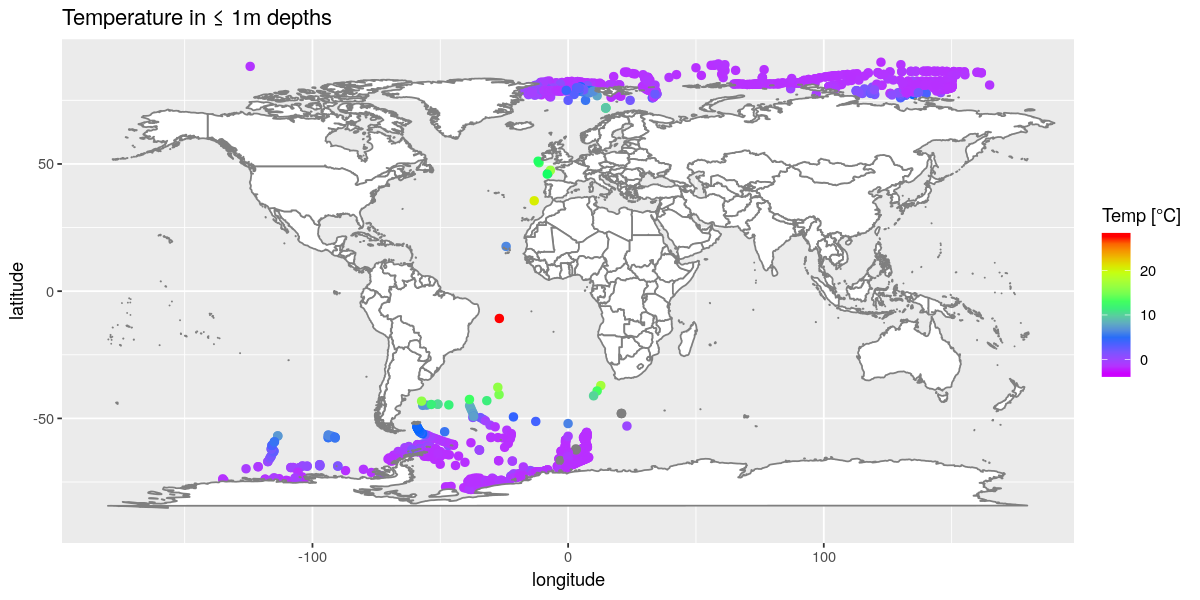

In [9]:
ggplot() +
    geom_point(data = d0001, aes(x = longitude, y = latitude, col = temperature), size = 2) +
    geom_map(data=WorldData, map=WorldData,aes(x=long, y=lat, group=group, map_id=region),fill="white", colour="#7f7f7f", size=0.5) +
    scale_color_gradientn(colors = rev(rainbow(5)), name = "Temp [°C]") +
    labs(title = "Temperature in \u2264 1m depths")+
    xlim(-180,180) +
    ylim(-90,90)

Warning message:
“Ignoring unknown aesthetics: x, y”

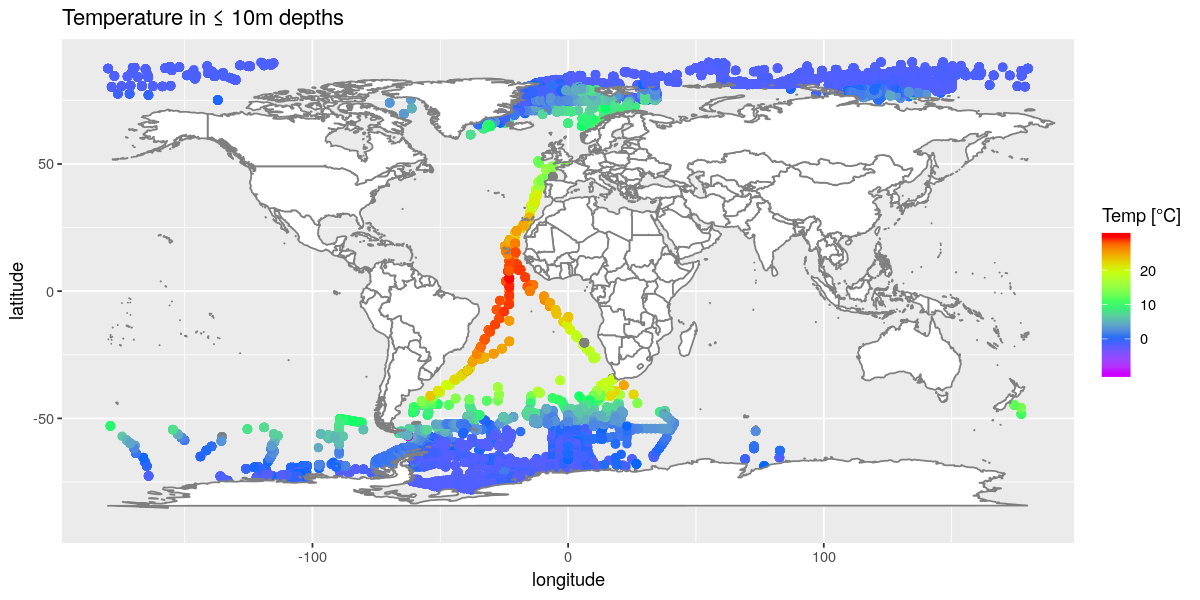

In [10]:
ggplot() +
    geom_point(data = d0010, aes(x = longitude, y = latitude, col = temperature), size = 2) +
    geom_map(data=WorldData, map=WorldData,aes(x=long, y=lat, group=group, map_id=region),fill="white", colour="#7f7f7f", size=0.5) +
    scale_color_gradientn(colors = rev(rainbow(5)), name = "Temp [°C]") +
    labs(title = "Temperature in \u2264 10m depths")+
    xlim(-180,180) +
    ylim(-90,90)

Warning message:
“Ignoring unknown aesthetics: x, y”

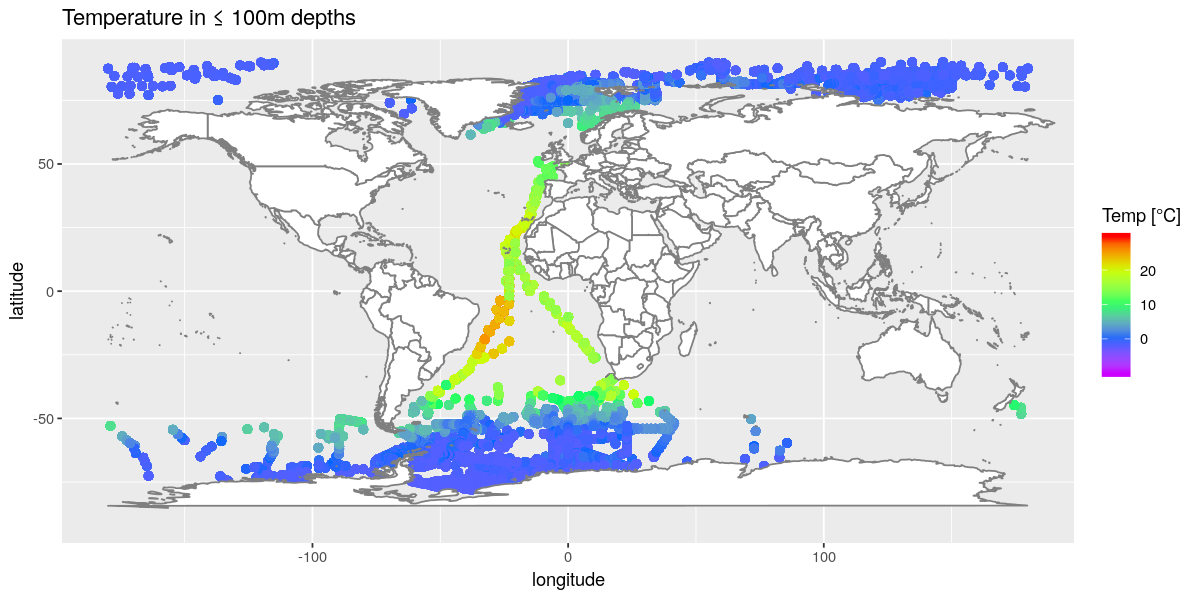

In [11]:
ggplot() +
    geom_point(data = d0100, aes(x = longitude, y = latitude, col = temperature), size = 2) +
    geom_map(data=WorldData, map=WorldData,aes(x=long, y=lat, group=group, map_id=region),fill="white", colour="#7f7f7f", size=0.5) +
    scale_color_gradientn(colors = rev(rainbow(5)), name = "Temp [°C]") +
    labs(title = "Temperature in \u2264 100m depths")+
    xlim(-180,180) +
    ylim(-90,90)

Warning message:
“Ignoring unknown aesthetics: x, y”Warning message:
“Removed 492123 rows containing missing values (geom_point).”

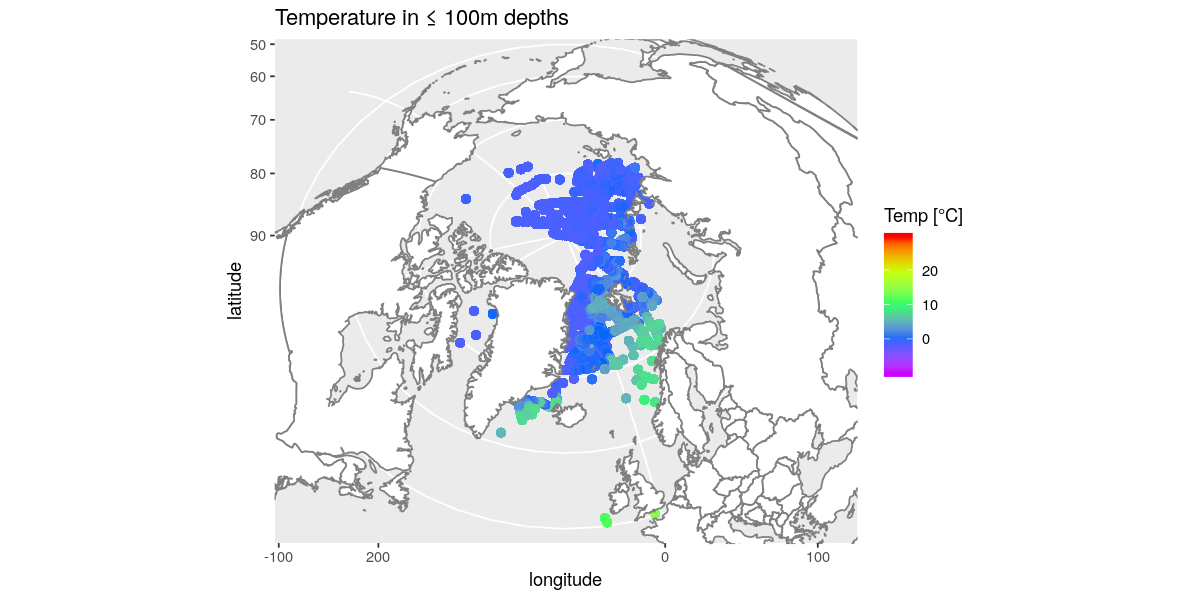

In [12]:
ggplot() +
    geom_point(data = d0100, aes(x = longitude, y = latitude, col = temperature), size = 2) +
    geom_map(data=WorldData, map=WorldData,aes(x=long, y=lat, group=group, map_id=region),fill="white", colour="#7f7f7f", size=0.5) +
    scale_color_gradientn(colors = rev(rainbow(5)), name = "Temp [°C]") +
    coord_map("ortho", orientation = c(60, -20, 0)) +
    ylim(50,90) +
    labs(title = "Temperature in \u2264 100m depths") 